In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [23]:
import torch
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.data import load_cifar_10
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report
import math
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from lightly.transforms import SimCLRTransform
from lightly.data import LightlyDataset
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.loss import NegativeCosineSimilarity
from torch.utils.data import DataLoader

In [24]:
dataset = load_cifar_10()

n_train=1000
n_pool=40000
n_test=20000
y=dataset.targets
x=dataset.data
classes=dataset.classes
class_1_idx=classes.index('frog')
class_1_mask=y==class_1_idx
y=class_1_mask.byte()
print(y)
print(len(y))
idx=torch.randperm(len(y))
train_data=x[idx[:n_train]]
train_targets=y[idx[:n_train]]

# pool_data=x[idx[n_train:-n_test]]
# pool_targets=y[idx[n_train:-n_test]]

test_data=x[idx[-n_test:]]
test_targets=y[idx[-n_test:]]

pool_data=x[idx[:n_pool]]
pool_targets=y[idx[:n_pool]]

print(train_data.shape)
print(train_targets.shape)
print(pool_data.shape)
print(pool_targets.shape)
print(test_data.shape)
print(test_targets.shape)

Files already downloaded and verified
Files already downloaded and verified
tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
60000
torch.Size([1000, 3, 32, 32])
torch.Size([1000])
torch.Size([40000, 3, 32, 32])
torch.Size([40000])
torch.Size([20000, 3, 32, 32])
torch.Size([20000])


In [4]:
import torchvision.transforms as transforms

# train_images = train_images / 255
#     # mean normalize
# train_images = (train_images - train_images.mean(dim=(0, 2, 3), keepdim=True)) / train_images.std(dim=(0, 2, 3), keepdim=True)
aug = transforms.Compose([
    # transforms.Resize(224),
    # transforms.RandomResizedCrop(224,scale=(0.2,1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=50),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [26]:
train_data=aug(train_data)
train_dataset = TensorDataset(train_data, train_targets)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
augmentaed_images = aug(pool_data) 

In [6]:
print(augmentaed_images.shape)

torch.Size([40000, 3, 32, 32])


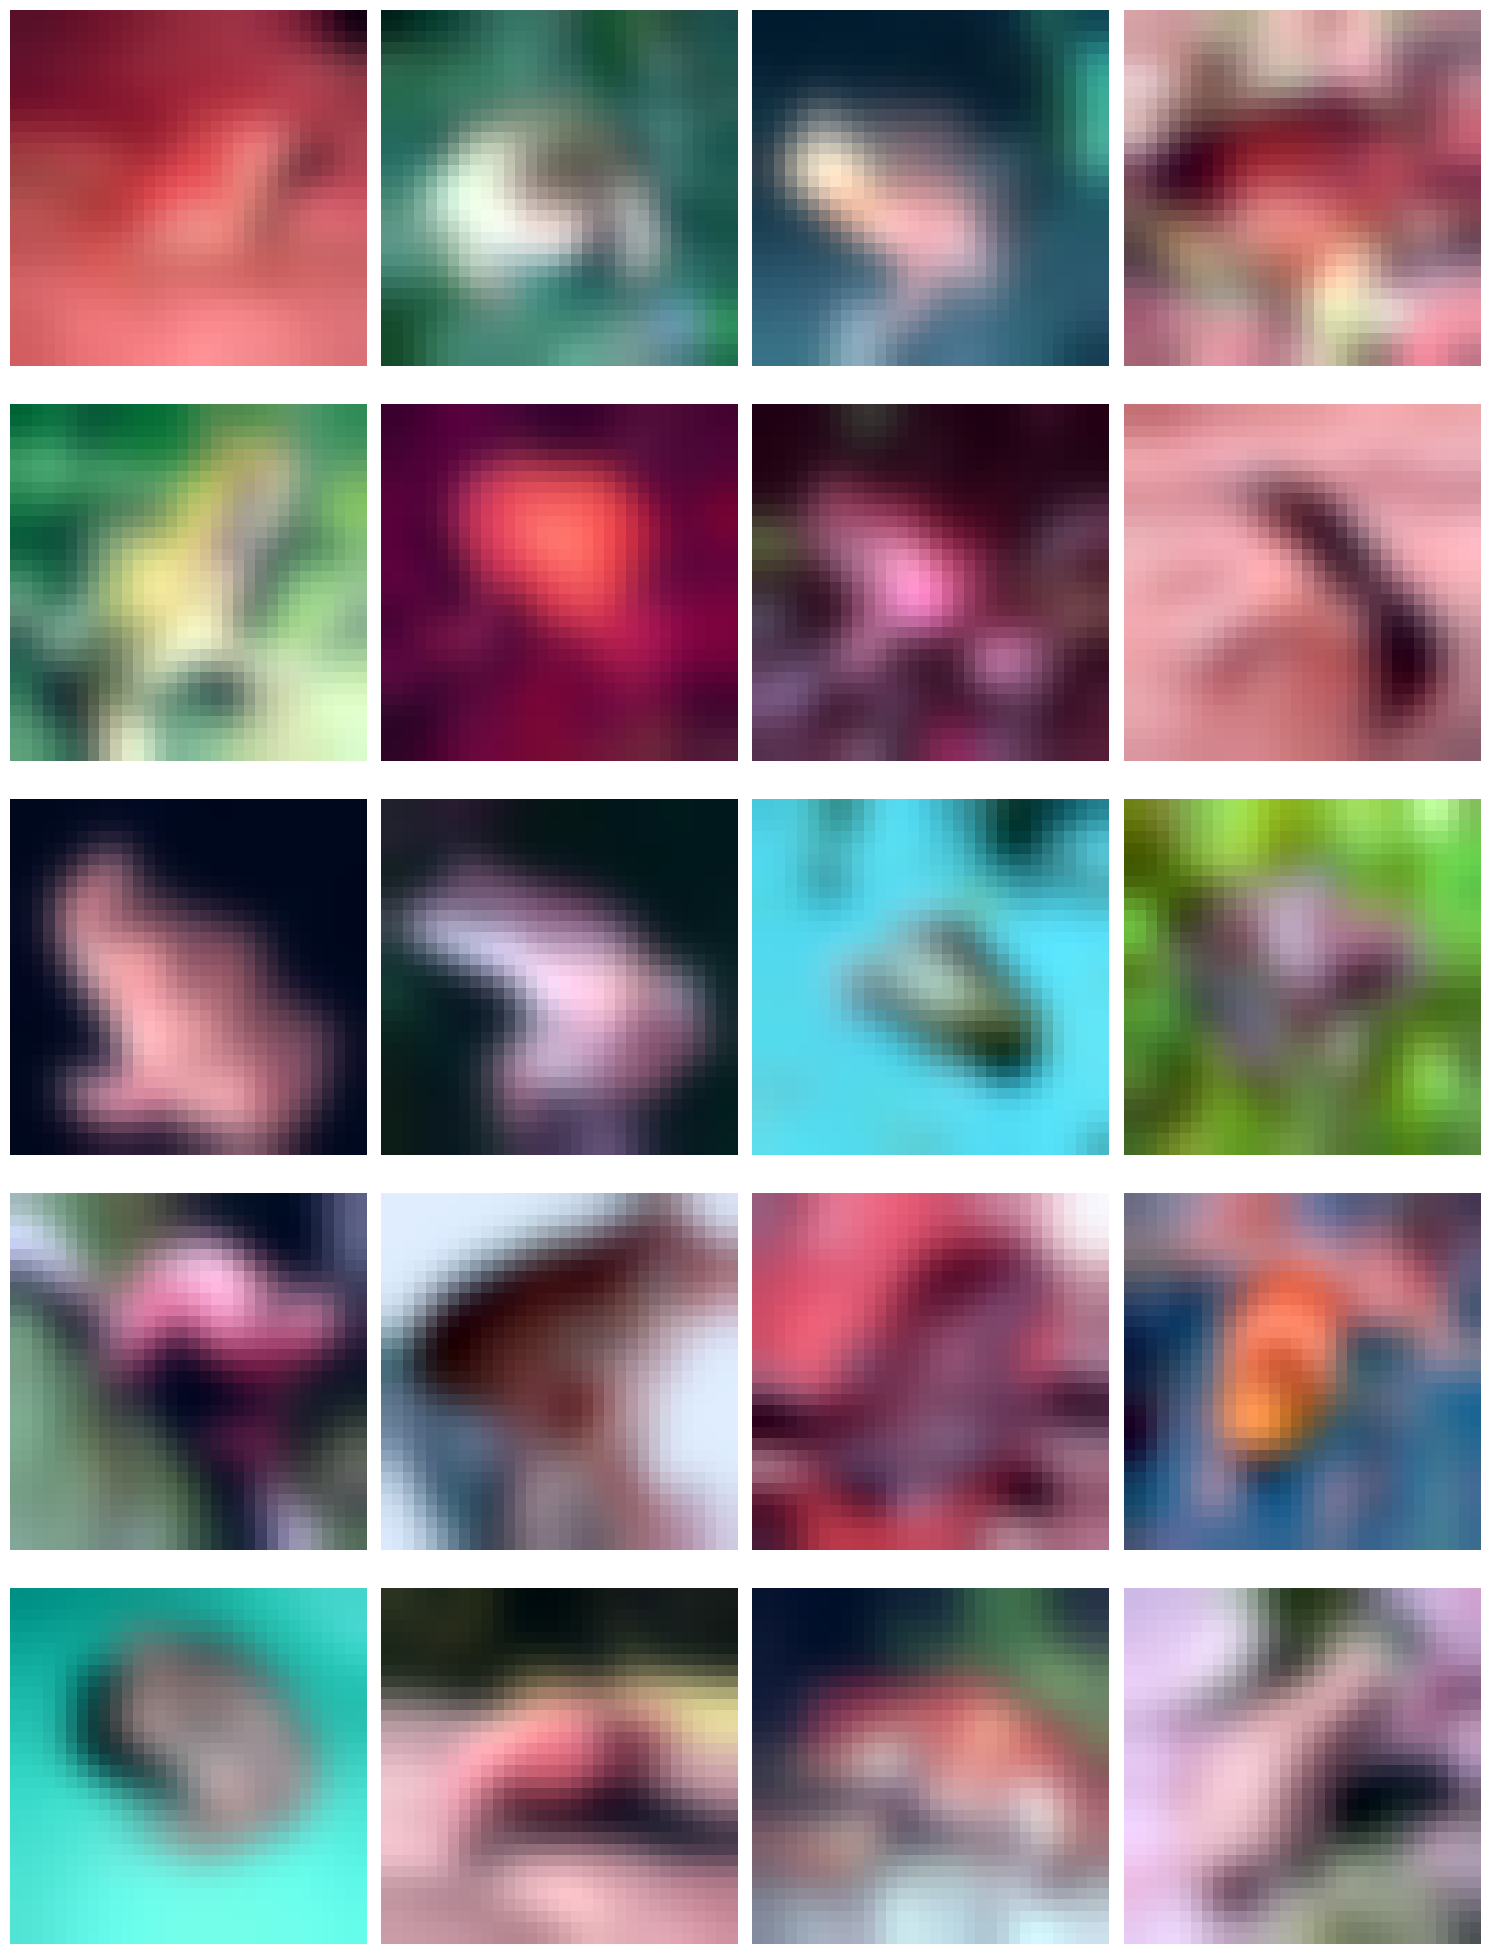

In [7]:
# Filter the images based on the label
label_1_images = augmentaed_images[pool_targets == 1]

# Plot the filtered images
fig, axes = plt.subplots(5, 4, figsize=(15,20))

for i in range(5):
    for j in range(4):
        # Adjust the index calculation to match the desired grid
        index = i * 4 + j
        if index < len(label_1_images):
            # Transpose the dimensions to (32, 32, 3) for RGB image
            image_to_display = label_1_images[index].permute(1, 2, 0)
            image_to_display = (image_to_display - image_to_display.min()) / (image_to_display.max() - image_to_display.min())

            axes[i, j].imshow(image_to_display)
            #put the label
            # axes[i, j].set_title(label_1_images[index].item())
            axes[i, j].axis('off')
        else:
            # If there are fewer than 20 images, remove empty subplots
            fig.delaxes(axes[i, j])
plt.tight_layout()
plt.show()

In [8]:
from torch.utils.data import TensorDataset, DataLoader
augmentaed_images1=aug(pool_data)
train_data=TensorDataset(augmentaed_images,augmentaed_images1,pool_targets)
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

In [9]:
import torchvision.transforms as transforms

# test_images = test_images / 255
#     # mean normalize
# test_images = (test_images - test_images.mean(dim=(0, 2, 3), keepdim=True)) / test_images.std(dim=(0, 2, 3), keepdim=True)
aug1 = transforms.Compose([
    # transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
test_images = aug1(test_data)
test_index=[]
for i in range(len(test_images)):
    test_index.append(i)
# print(test_index)
test_index=torch.tensor(test_index)
test_data=TensorDataset(test_images,test_targets,test_index)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=8)

In [12]:
class SimSiam(nn.Module):
    def __init__(self,backbone,num_ftrs=512,proj_hidden_dim=512,pred_hidden_dim=128,out_dim=128):
        super(SimSiam, self).__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)

    def forward(self, x):
        #get representation
        f= self.backbone(x).flatten(start_dim=1)
        #get projection
        z=self.projection_head(f)
        #get prediction
        p=self.prediction_head(z)
        #stop gradient
        z = z.detach()
        return z,p

In [13]:
resnet = torchvision.models.resnet18()
# print("Resnet",resnet)
backbone = nn.Sequential(*list(resnet.children())[:-1])
# print("BAckbone",backbone)
model = SimSiam(backbone, num_ftrs=512, proj_hidden_dim=512, pred_hidden_dim=128, out_dim=512)
# print("Model",model)    


In [14]:
batch_size = 128
criterion = NegativeCosineSimilarity()
lr =0.001
print("Learning rate",lr)   
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

Learning rate 0.001


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
avg_loss = 0.0    
avg_output_std = 0.0
epochs = 50

for e in range(epochs):
    for x0, x1, _ in dataloader_train_simsiam:
        x0 = x0.to(device)
        x1 = x1.to(device)
        zo,po = model(x0)
        z1,p1 = model(x1)
        loss=0.5*(criterion(zo,p1)+criterion(z1,po))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        output=po.detach()
        output=torch.nn.functional.normalize(output,dim=1)
        output_std=torch.std(output, dim=0)
        avg_output_std += output_std.mean()
        w=0.9
        avg_loss = w*avg_loss + (1-w)*loss.item()
    print(
        f"[Epoch {e:3d}] "
        f"Loss = {avg_loss:.2f} | "
    )


[Epoch   0] Loss = -0.12 | 
[Epoch   1] Loss = -0.47 | 
[Epoch   2] Loss = -0.71 | 
[Epoch   3] Loss = -0.80 | 
[Epoch   4] Loss = -0.85 | 
[Epoch   5] Loss = -0.87 | 
[Epoch   6] Loss = -0.88 | 
[Epoch   7] Loss = -0.88 | 
[Epoch   8] Loss = -0.89 | 
[Epoch   9] Loss = -0.90 | 
[Epoch  10] Loss = -0.91 | 
[Epoch  11] Loss = -0.93 | 
[Epoch  12] Loss = -0.94 | 
[Epoch  13] Loss = -0.95 | 
[Epoch  14] Loss = -0.95 | 
[Epoch  15] Loss = -0.96 | 
[Epoch  16] Loss = -0.96 | 
[Epoch  17] Loss = -0.96 | 
[Epoch  18] Loss = -0.97 | 
[Epoch  19] Loss = -0.97 | 
[Epoch  20] Loss = -0.97 | 
[Epoch  21] Loss = -0.97 | 
[Epoch  22] Loss = -0.97 | 
[Epoch  23] Loss = -0.97 | 
[Epoch  24] Loss = -0.97 | 
[Epoch  25] Loss = -0.97 | 
[Epoch  26] Loss = -0.97 | 
[Epoch  27] Loss = -0.97 | 
[Epoch  28] Loss = -0.97 | 
[Epoch  29] Loss = -0.97 | 
[Epoch  30] Loss = -0.97 | 
[Epoch  31] Loss = -0.97 | 
[Epoch  32] Loss = -0.97 | 
[Epoch  33] Loss = -0.98 | 
[Epoch  34] Loss = -0.98 | 
[Epoch  35] Loss = -

In [16]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [27]:
classifier = Classifier(input_dim=512, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 50
for epochs in range(num_epochs):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        f1=model.backbone(x).flatten(start_dim=1)
        optimizer.zero_grad()
        output = classifier(f1)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epochs + 1}/{num_epochs}], Classifier Loss: {loss.item():.4f}')

Epoch [1/50], Classifier Loss: 0.5687
Epoch [2/50], Classifier Loss: 0.2597
Epoch [3/50], Classifier Loss: 0.2424
Epoch [4/50], Classifier Loss: 0.3958
Epoch [5/50], Classifier Loss: 0.3098
Epoch [6/50], Classifier Loss: 0.2637
Epoch [7/50], Classifier Loss: 0.2423
Epoch [8/50], Classifier Loss: 0.4026
Epoch [9/50], Classifier Loss: 0.1758
Epoch [10/50], Classifier Loss: 0.2364
Epoch [11/50], Classifier Loss: 0.4713
Epoch [12/50], Classifier Loss: 0.2678
Epoch [13/50], Classifier Loss: 0.3683
Epoch [14/50], Classifier Loss: 0.2273
Epoch [15/50], Classifier Loss: 0.3135
Epoch [16/50], Classifier Loss: 0.3026
Epoch [17/50], Classifier Loss: 0.3798
Epoch [18/50], Classifier Loss: 0.2817
Epoch [19/50], Classifier Loss: 0.1773
Epoch [20/50], Classifier Loss: 0.3501
Epoch [21/50], Classifier Loss: 0.2945
Epoch [22/50], Classifier Loss: 0.3271
Epoch [23/50], Classifier Loss: 0.2810
Epoch [24/50], Classifier Loss: 0.2587
Epoch [25/50], Classifier Loss: 0.2981
Epoch [26/50], Classifier Loss: 0.

In [30]:
classifier.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs, targets,_= batch
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        f11=model.backbone(inputs).flatten(start_dim=1)
        # z11=model.projection_head(f11)
        # p11=model.prediction_head(z11)
        outputs = classifier(f11)
        predictions=torch.argmax(outputs,dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
all_predictions = np.array(all_predictions)
all_labels = np.array(all_targets)
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the predictions and ground truth labels from the previous code

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute and display classification report
class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[17898    62]
 [ 2003    37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17960
           1       0.37      0.02      0.03      2040

    accuracy                           0.90     20000
   macro avg       0.64      0.51      0.49     20000
weighted avg       0.85      0.90      0.85     20000



: 